# **1. 시퀀스 데이터**
시퀀스 데이터(Sequence Data)는 시간적 혹은 순서적 관계가 중요한 데이터를 말합니다. 일반적인 데이터가 순서와 무관하게 독립적으로 다뤄지는 것과 달리, 시퀀스 데이터는 각 요소가 특정 순서에 따라 나열되어 있고 앞뒤 맥락이 의미를 가집니다. 대표적인 예로는 자연어 문장(단어의 순서 중요), 시계열 데이터(주가, 날씨 변화), 음성 신호(시간에 따른 파형), 영상 프레임(연속된 이미지) 등이 있습니다. 따라서 시퀀스 데이터는 단순한 값들의 모음이 아니라, 순서와 맥락이 포함된 정보 구조로 이해하는 것이 핵심입니다.

# **2. RNN**
RNN(Recurrent Neural Network, 순환 신경망)은 시계열 데이터나 연속적인 데이터를 다룰 때 사용되는 인공 신경망으로, 일반적인 신경망(CNN, MLP 등)이 입력을 한 번 처리하고 끝나는 것과 달리, 과거의 정보를 기억하며 다음 계산에 반영하는 특징이 있습니다. 일반적인 신경망은 현재 입력만 보고 예측하지만, 시계열 데이터나 자연어처럼 이전 정보가 중요한 경우에는 적절하지 않기 때문에 RNN이 필요합니다. RNN은 기존 신경망과 달리 자신의 출력을 다시 입력으로 사용하여 과거 정보를 기억하는 구조를 가지며, 이를 통해 시계열 데이터의 패턴을 학습할 수 있습니다.  그러나 일반적인 RNN은 장기 의존성(Long-Term Dependency) 문제로 인해 학습이 어려울 수 있으며, 이를 해결하기 위해 장단기 메모리(Long Short-Term Memory, LSTM)나 게이트 순환 유닛(Gated Recurrent Unit, GRU)과 같은 변형 모델이 개발되었습니다.

<img src="https://blog.kakaocdn.net/dna/dVaNhP/btsL7gh0fgx/AAAAAAAAAAAAAAAAAAAAAAwNLiDocUQPAciWVZGXyIIGxbsuL1Hqs8bQ5W7BA2_4/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=8N5fTlGr4eOWZVKRWOTxgAawfvM%3D">

<img src="https://blog.kakaocdn.net/dna/bmt1u0/btsP7bXvObp/AAAAAAAAAAAAAAAAAAAAAItFvW9XMJosd1e6Q2sgH1zDaTOfz7l8YZsfevc10kNw/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=Y05mTYU%2FSi1bM60%2Fq1Jr%2FWg6suM%3D" width=500>

>은닉층에 있는 RNN의 처리 단위를 셀(cell)이라고 부르며, 셀의 출력을 은닉 상태(hidden state)라고 합니다. RNN은 시점(time step)에 따라서 입력을 받는데 현재 시점의 hidden state인 h𝑡연산을 위해 직전 시점의 hidden state인 h𝑡−1를 입력받습니다. 이것이 RNN이 과거의 정보를 기억할 수 있는 방법입니다.

<img src="https://blog.kakaocdn.net/dna/HGHef/btsL5Qkxoi5/AAAAAAAAAAAAAAAAAAAAAD9pmNCzz3qG1qF24-bPaTE6IY3PHjp2BHrfjzLBJTkk/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1756652399&allow_ip=&allow_referer=&signature=96oEBd21t819ImE%2F%2BkT7jOzWIKo%3D" width=600>

>하이퍼볼릭탄젠트 함수는 시그모이드 함수와 달리 -1 ~ 1의 범위 값으로 값을 반환하는 함수입니다. 반환값의 범위가 시그모이드 함수보다 크므로 일반적으로 은닉층에서는 시그모이드 함수보다 더 잘 동작합니다.

# **2. RNN 모델로 이미지 분류하기**


In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset

In [2]:
train_dataset = dset.MNIST(root='.',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dset.MNIST(root='.',
                          train=False,
                          transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 602kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.02MB/s]


In [3]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        # out: 모든 시점의  은닉 출력(배치, 길이, hidden_dim)
        # hn : 각 층의 마지막시점 은닉 상태(num_lauers, 배치,. hidden_dim)
        out, hn = self.rnn(x, h0)
        # RNN은 매 시점의 이전까지의 정보를 누적하여 마지막 시점에서 전체 시퀀스 요약
        out = self.fc(out[:, -1, :])
        return out

In [16]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model

RNNModel(
  (rnn): RNN(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
num_epochs = 20


for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.view(-1, input_dim, input_dim)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.view(-1, 28, input_dim)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / total

    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

Epoch: 0. Loss: 1.7870230674743652. Accuracy: 31.6299991607666
Epoch: 1. Loss: 1.07919442653656. Accuracy: 61.970001220703125
Epoch: 2. Loss: 0.9583304524421692. Accuracy: 72.23999786376953
Epoch: 3. Loss: 0.7876265048980713. Accuracy: 79.05999755859375
Epoch: 4. Loss: 0.7087843418121338. Accuracy: 82.70999908447266
Epoch: 5. Loss: 0.5662186145782471. Accuracy: 84.94999694824219
Epoch: 6. Loss: 0.29851314425468445. Accuracy: 89.70999908447266
Epoch: 7. Loss: 0.3209007680416107. Accuracy: 89.69000244140625
Epoch: 8. Loss: 0.2669423520565033. Accuracy: 91.62000274658203
Epoch: 9. Loss: 0.24949043989181519. Accuracy: 91.62000274658203
Epoch: 10. Loss: 0.2959693968296051. Accuracy: 93.12000274658203
Epoch: 11. Loss: 0.29977965354919434. Accuracy: 93.33999633789062
Epoch: 12. Loss: 0.3631380796432495. Accuracy: 93.22000122070312
Epoch: 13. Loss: 0.10357007384300232. Accuracy: 94.45999908447266
Epoch: 14. Loss: 0.09347011893987656. Accuracy: 94.79000091552734
Epoch: 15. Loss: 0.0966717973351

# **3. RNN을 이용한 KOSPI 예측**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
df = pd.read_csv('/content/drive/MyDrive/AI활용 소프트웨어 개발/13. 생성형 AI/data/kospi.csv')
if 'Date' in df.columns:
    # 변환이 불가할 경우 결측치로 변환
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

# 결측치가 있다면
# 2000-01-02, 2000-01-06, NaN, NaN, 2000-01-08
df = df.ffill().bfill()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-02,955.440002,959.309998,923.520020,928.750000,928.750000,30614300.0
1,2000-01-06,730.549988,746.700012,722.239990,738.489990,738.489990,31433500.0
2,2000-01-08,710.049988,727.530029,700.830017,727.099976,727.099976,29793900.0
3,2000-01-09,690.929993,698.280029,685.320007,692.190002,692.190002,20236900.0
4,2000-01-11,524.690002,550.059998,522.780029,548.760010,548.760010,36644300.0
...,...,...,...,...,...,...,...
4508,2018-12-01,2504.159912,2524.550049,2498.550049,2521.739990,2521.739990,341600.0
4509,2018-12-01,2517.189941,2521.969971,2506.489990,2515.429932,2515.429932,336700.0
4510,2018-12-01,2527.669922,2532.080078,2512.689941,2515.810059,2515.810059,333100.0
4511,2018-12-01,2519.669922,2524.330078,2513.090088,2520.260010,2520.260010,351800.0


In [6]:
FEATS = ['Open', 'High', 'Low', 'Close']

split_ratio = 0.5
split_idx = int(len(df) * split_ratio)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = train_df[FEATS].values
X_test  = test_df[FEATS].values
y_train = train_df[['Close']].values   # (N,1) 모양
y_test  = test_df[['Close']].values

X_train = scaler_x.fit_transform(X_train)
X_test  = scaler_x.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test  = scaler_y.transform(y_test)

In [7]:
def make_seq(X, y, L: int):
    Xs, ys = [], []
    for i in range(len(X) - L):
        Xs.append(X[i:i+L])     # (L, feat)
        ys.append(y[i+L])       # 다음 시점 y
    Xs = torch.tensor(np.array(Xs), dtype=torch.float32)
    ys = torch.tensor(np.array(ys), dtype=torch.float32).view(-1, 1)
    return Xs, ys

In [8]:
sequence_length = 5
X_train, y_train = make_seq(X_train, y_train, sequence_length)
X_test,  y_test  = make_seq(X_test,  y_test,  sequence_length)

print("Train seq:", X_train.shape, y_train.shape)
print("Test  seq:", X_test.shape,  y_test.shape)

Train seq: torch.Size([2251, 5, 4]) torch.Size([2251, 1])
Test  seq: torch.Size([2252, 5, 4]) torch.Size([2252, 1])


In [9]:
X_train

tensor([[[0.2335, 0.2331, 0.2213, 0.2202],
         [0.1261, 0.1313, 0.1245, 0.1291],
         [0.1163, 0.1222, 0.1142, 0.1237],
         [0.1072, 0.1082, 0.1067, 0.1069],
         [0.0278, 0.0372, 0.0285, 0.0383]],

        [[0.1261, 0.1313, 0.1245, 0.1291],
         [0.1163, 0.1222, 0.1142, 0.1237],
         [0.1072, 0.1082, 0.1067, 0.1069],
         [0.0278, 0.0372, 0.0285, 0.0383],
         [0.0116, 0.0202, 0.0125, 0.0219]],

        [[0.1163, 0.1222, 0.1142, 0.1237],
         [0.1072, 0.1082, 0.1067, 0.1069],
         [0.0278, 0.0372, 0.0285, 0.0383],
         [0.0116, 0.0202, 0.0125, 0.0219],
         [0.2212, 0.2287, 0.2212, 0.2273]],

        ...,

        [[0.0748, 0.0731, 0.0735, 0.0747],
         [0.0751, 0.0743, 0.0732, 0.0728],
         [0.0709, 0.0683, 0.0665, 0.0644],
         [0.0681, 0.0668, 0.0647, 0.0619],
         [0.0629, 0.0616, 0.0582, 0.0572]],

        [[0.0751, 0.0743, 0.0732, 0.0728],
         [0.0709, 0.0683, 0.0665, 0.0644],
         [0.0681, 0.0668, 0.0647

In [11]:
X_test

tensor([[[0.0624, 0.0631, 0.0624, 0.0625],
         [0.0789, 0.0773, 0.0720, 0.0696],
         [0.0688, 0.0692, 0.0686, 0.0676],
         [0.0702, 0.0709, 0.0684, 0.0721],
         [0.0729, 0.0720, 0.0694, 0.0680]],

        [[0.0789, 0.0773, 0.0720, 0.0696],
         [0.0688, 0.0692, 0.0686, 0.0676],
         [0.0702, 0.0709, 0.0684, 0.0721],
         [0.0729, 0.0720, 0.0694, 0.0680],
         [0.0655, 0.0629, 0.0622, 0.0611]],

        [[0.0688, 0.0692, 0.0686, 0.0676],
         [0.0702, 0.0709, 0.0684, 0.0721],
         [0.0729, 0.0720, 0.0694, 0.0680],
         [0.0655, 0.0629, 0.0622, 0.0611],
         [0.0570, 0.0621, 0.0583, 0.0638]],

        ...,

        [[0.9334, 0.9402, 0.9372, 0.9419],
         [0.9422, 0.9550, 0.9496, 0.9567],
         [0.9764, 0.9769, 0.9779, 0.9740],
         [0.9732, 0.9823, 0.9791, 0.9827],
         [0.9794, 0.9810, 0.9829, 0.9796]],

        [[0.9422, 0.9550, 0.9496, 0.9567],
         [0.9764, 0.9769, 0.9779, 0.9740],
         [0.9732, 0.9823, 0.9791

In [12]:
y_train

tensor([[0.0219],
        [0.2273],
        [0.2039],
        ...,
        [0.0468],
        [0.0480],
        [0.0616]])

In [13]:
y_test

tensor([[0.0611],
        [0.0638],
        [0.0631],
        ...,
        [0.9798],
        [0.9820],
        [0.9733]])

In [15]:
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test),
                          batch_size=batch_size, shuffle=False, drop_last=False)

In [16]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)  # tanh 기본
        self.fc = nn.Linear(hidden_size, 1)    # << Sigmoid 제거(회귀)
    def forward(self, x):
        B = x.size(0)
        h0 = torch.zeros(self.rnn.num_layers, B, self.rnn.hidden_size, device=x.device)
        out, _ = self.rnn(x, h0)               # out: [B, L, H]
        last = out[:, -1, :]                   # 마지막 시점 은닉만 사용
        yhat = self.fc(last)                   # 선형 출력
        return yhat


In [22]:
input_size  = X_train.size(2)             # 4
hidden_size = 32
num_layers  = 2
model = RNNRegressor(input_size, hidden_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model

RNNRegressor(
  (rnn): RNN(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
epochs = 200
clip_norm = 1.0

for epoch in range(1, epochs+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)   # [B, L, 4]
        yb = yb.to(device)   # [B, 1]

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        # ReLU RNN을 쓸 경우 특히 유용하지만 tanh에도 안전장치로 둡니다.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()

        running += loss.item()

    if epoch % 20 == 0 or epoch == 1:
        print(f"[{epoch:03d}/{epochs}] train MSE: {running/len(train_loader):.6f}")

[001/200] train MSE: 0.009981
[020/200] train MSE: 0.003416
[040/200] train MSE: 0.003378
[060/200] train MSE: 0.003421
[080/200] train MSE: 0.003353
[100/200] train MSE: 0.003355
[120/200] train MSE: 0.003294
[140/200] train MSE: 0.003280
[160/200] train MSE: 0.003196
[180/200] train MSE: 0.003124
[200/200] train MSE: 0.003157


In [20]:
model.eval()
pred_list, true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb)                # 스케일된 예측
        pred_list.append(pred.cpu().numpy())
        true_list.append(yb.cpu().numpy())

pred_scaled = np.vstack(pred_list)      # (N_test, 1)
true_scaled = np.vstack(true_list)

# 원 스케일로 되돌리기(inverse transform)
pred_unscaled = scaler_y.inverse_transform(pred_scaled)
true_unscaled = scaler_y.inverse_transform(true_scaled)

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = mean_squared_error(true_unscaled, pred_unscaled)
mae  = mean_absolute_error(true_unscaled, pred_unscaled)
print(f"Test RMSE: {rmse:.4f} | MAE: {mae:.4f}")

print("예측(앞 5개):", np.round(pred_unscaled[:5, 0], 2))
print("실제(앞 5개):", np.round(true_unscaled[:5, 0], 2))

Test RMSE: 3695.4417 | MAE: 47.0789
예측(앞 5개): [649.25 645.92 641.59 643.21 642.75]
실제(앞 5개): [596.36 602.08 600.57 595.38 611.51]


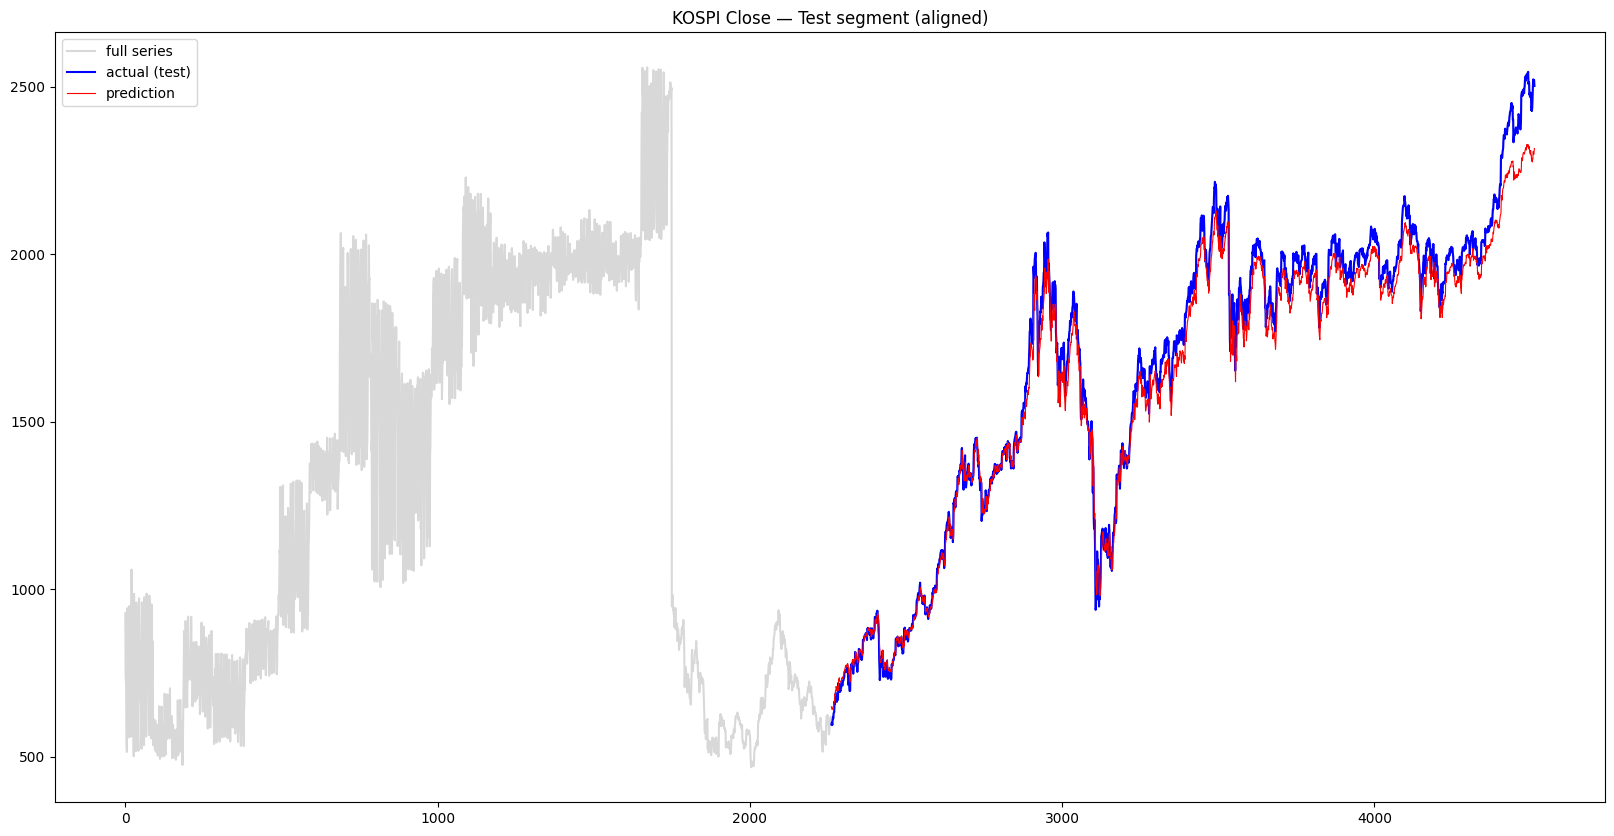

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 기준 인덱스들
L = sequence_length          # 예: 5
t0 = split_idx               # train/test 절단 시점 (원본 df 기준)
N_pred = len(pred_unscaled)  # 테스트 예측 길이 = len(test_df) - L

# 2) 실제값(테스트 구간)과 예측값 준비
y_actual_test = df['Close'].values[t0 + L : t0 + L + N_pred]   # 테스트 구간 실제 종가
y_pred_test   = pred_unscaled.ravel()                          # 예측(원 스케일)

# 3) x축(원본 인덱스)에 정확히 맞춰 그림
x_test = np.arange(t0 + L, t0 + L + N_pred)

plt.figure(figsize=(20, 10))

plt.plot(df['Close'].values, color='gray', alpha=0.3, label='full series')

# 테스트 실제/예측 정렬해서 겹치기
plt.plot(x_test, y_actual_test, 'b', label='actual (test)')
plt.plot(x_test, y_pred_test, 'r', linewidth=0.8, label='prediction')

plt.legend()
plt.title('KOSPI Close — Test segment (aligned)')
plt.show()